In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
# import some common libraries
import numpy as np
import torch
import os, json, cv2, random

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Dataset

In [4]:
import os
import json
import cv2
import numpy as np
import pycocotools.mask
import random
from PIL import Image
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from collections import defaultdict

def build_kitti_mots_dicts(dataset_path, instances_ids=None):
    # Check that the dataset path exists and is a directory.
    assert os.path.isdir(dataset_path), f"Dataset path '{dataset_path}' is not a directory or does not exist."

    ann_dir = os.path.join(dataset_path, "instances_txt")
    images_folder = os.path.join(dataset_path, "training", "image_02")

    # Check that the annotation directory exists.
    assert os.path.isdir(ann_dir), f"Annotation directory '{ann_dir}' does not exist or is not a directory."
    # Check that the images folder exists.
    assert os.path.isdir(images_folder), f"Images folder '{images_folder}' does not exist or is not a directory."

    dataset_dicts = []
    category_map = {1: 1, 2: 0}  # car -> 1, pedestrian -> 0

    # Iterate over each instance directory in the images folder.
    for instance_dir in sorted(os.listdir(images_folder)):
        instance_dir_path = os.path.join(images_folder, instance_dir)
        if not os.path.isdir(instance_dir_path):
            continue  # Skip non-directory entries

        try:
            instance_number = int(instance_dir)
        except ValueError:
            continue

        if instances_ids and instance_number not in instances_ids:
            continue

        instance_path = instance_dir_path
        ann_file = os.path.join(ann_dir, f"{instance_number:04d}.txt")
        
        annotations = defaultdict(list)
        if os.path.exists(ann_file):
            # Make sure ann_file is a file.
            assert os.path.isfile(ann_file), f"Annotation file '{ann_file}' exists but is not a file."
            with open(ann_file, "r") as file:
                for line in file:
                    parts = line.strip().split(" ")
                    # Validate that the annotation line has at least 6 parts.
                    if len(parts) < 6:
                        raise ValueError(f"Annotation line has less than 6 parts: {line}")
                    try:
                        time_frame = int(parts[0])
                        class_id = int(parts[2])
                        img_height = int(parts[3])
                        img_width = int(parts[4])
                    except ValueError:
                        raise ValueError(f"Annotation line contains non-integer values where expected: {line}")

                    # Validate that image dimensions are positive.
                    assert img_height > 0 and img_width > 0, f"Invalid image dimensions in annotation: {img_height}x{img_width}"

                    rle = parts[5].strip()
                    # Validate that RLE string is not empty.
                    assert rle, f"Empty RLE in annotation line: {line}"

                    # If the class id is 10, skip this annotation.
                    if class_id == 10:
                        continue

                    # Ensure that the class_id is in the category_map.
                    assert class_id in category_map, f"Class ID {class_id} is not in the category_map {category_map}"

                    mask = {"counts": rle, "size": [img_height, img_width]}
                    bbox = pycocotools.mask.toBbox(mask).tolist()
                    
                    """ IMPLEMENT IF SEGMENTATION IS NEEDED
                    # Convert to uint8 image for contour extraction.
                    segmentation = pycocotools.mask.decode(mask)
                    # Check that the segmentation mask dimensions match the expected image dimensions.
                    assert segmentation.shape[0] == img_height and segmentation.shape[1] == img_width, (
                        f"Segmentation shape {segmentation.shape} does not match expected dimensions [{img_height}, {img_width}]"
                    )
                    seg_uint8 = segmentation.astype(np.uint8)
                    contours, hierarchy = cv2.findContours(seg_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    # Ensure that at least one contour was found.
                    assert contours is not None and len(contours) > 0, f"No contours found in segmentation for annotation line: {line}"
                    polygons = [contour.flatten().tolist() for contour in contours if len(contour) >= 6]
                    # Ensure that at least one valid polygon exists.
                    assert len(polygons) > 0, f"No valid polygon (at least 3 points) found in annotation line: {line}"
                    """
                    polygons = []
                    
                    # Validate that the bounding box values are non-negative and have positive width/height.
                    x, y, w, h = bbox
                    assert x >= 0 and y >= 0 and w > 0 and h > 0, f"Invalid bbox values: {bbox}"

                    # Create a unique image ID
                    image_id = int(f"{instance_number:04d}{time_frame:06d}")

                    annotations[image_id].append({
                        "bbox": bbox,
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": polygons,
                        "category_id": category_map[class_id],
                    })

        # Check that the instance_path exists and is a directory.
        assert os.path.isdir(instance_path), f"Instance path '{instance_path}' is not a directory."
        image_files = sorted(os.listdir(instance_path))
        # Ensure that the instance directory contains image files.
        assert len(image_files) > 0, f"No image files found in instance directory '{instance_path}'."
        for img_file in image_files:
            # Process only valid image files based on extension.
            if not img_file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                continue
            try:
                time_frame = int(os.path.splitext(img_file)[0])
            except ValueError:
                raise ValueError(f"Image filename '{img_file}' does not contain a valid integer time frame.")
            image_id = int(f"{instance_number:04d}{time_frame:06d}")
            file_path = os.path.join(instance_path, img_file)
            # Verify that the image file exists.
            assert os.path.isfile(file_path), f"Image file '{file_path}' does not exist or is not a file."
            # Open image and check dimensions.
            with Image.open(file_path) as img:
                width, height = img.size
                # Validate that the image dimensions are positive.
                assert width > 0 and height > 0, f"Image '{file_path}' has invalid dimensions: {width}x{height}"

            record = {
                "file_name": file_path,
                "image_id": image_id,
                "height": height,
                "width": width,
                "annotations": annotations[image_id],
            }
            dataset_dicts.append(record)

    # Final check: ensure that the dataset is not empty.
    assert len(dataset_dicts) > 0, "No data found in dataset, please check the dataset path and structure."
    return dataset_dicts

In [6]:
DatasetCatalog.register("kitti_mots", lambda: build_kitti_mots_dicts("/home/mcv/datasets/C5/KITTI-MOTS", instances_ids=[1, 2, 3]))
MetadataCatalog.get("kitti_mots").set(thing_classes=["pedestrian", "car"])

kitti_mots_metadata = MetadataCatalog.get("kitti_mots")

In [7]:
dataset_dicts = build_kitti_mots_dicts("/home/mcv/datasets/C5/KITTI-MOTS")

/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0015/000195.png {'file_name': '/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0015/000195.png', 'image_id': 15000195, 'height': 370, 'width': 1224, 'annotations': [{'bbox': [0.0, 230.0, 288.0, 140.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [447.0, 174.0, 56.0, 35.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [970.0, 160.0, 44.0, 98.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [991.0, 163.0, 28.0, 98.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}]}


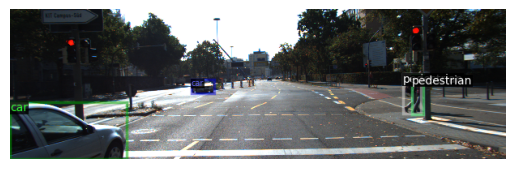

/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0003/000078.png {'file_name': '/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0003/000078.png', 'image_id': 3000078, 'height': 375, 'width': 1242, 'annotations': [{'bbox': [546.0, 180.0, 71.0, 63.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [20.0, 179.0, 103.0, 36.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}]}


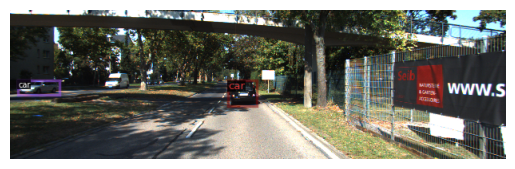

/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0001/000050.png {'file_name': '/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0001/000050.png', 'image_id': 1000050, 'height': 375, 'width': 1242, 'annotations': [{'bbox': [0.0, 205.0, 88.0, 170.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [470.0, 189.0, 60.0, 45.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [86.0, 199.0, 227.0, 112.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [358.0, 197.0, 75.0, 44.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [628.0, 182.0, 32.0, 24.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [521.0, 189.0, 26.0, 26.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}, {'bbox': [712.0, 172.0, 92.0, 30.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 1}

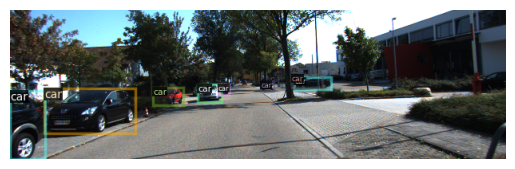

In [8]:
random.seed(42)
for d in random.sample(dataset_dicts, 3):
    print(d["file_name"], d)
    img = cv2.imread(d["file_name"])[:, :, ::-1]
    visualizer = Visualizer(img, metadata=kitti_mots_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

### Task (c): Run inference with pre-trained Faster R-CNN, DeTR and YOLOv(>8) on KITTI-MOTS dataset .

In [24]:
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")
# Output folder
cfg.OUTPUT_DIR = "/ghome/c5mcv07/C5_G7_MCV/Task1/faster-rcnn/output/pre_trained_inference"
cfg.MODEL.DEVICE = device

In [25]:
# Run inference on all images
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
predictor = DefaultPredictor(cfg)
for d in dataset_dicts:
    file_name = d["file_name"]
    image_id = d["image_id"]
    img = cv2.imread(file_name)
    outputs = predictor(img)  # Run inference

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    folder, file = file_name.split("/")[-2:]
    os.makedirs(f"{cfg.OUTPUT_DIR}/{folder}", exist_ok=True)
    output_file = f"{cfg.OUTPUT_DIR}/{folder}/{file}"
    cv2.imwrite(output_file, out.get_image()[:, :, ::-1])

[03/05 20:26:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_DC5_3x/137849425/model_final_68d202.pkl ...


model_final_68d202.pkl: 663MB [00:24, 26.7MB/s]                               


KeyboardInterrupt: 

### Task (d): Evaluate pre-trained Faster R-CNN, DeTR and YOLOv(>8) on KITTI-MOTS dataset.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("kitti_mots_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "kitti_mots_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

### Task (e): Fine-tune Faster R-CNN, DeTR and YOLO on KITTI-MOTS (Similar Domain)

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ()
cfg.DATASETS.TEST = ("kitti_mots_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()